### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

In [69]:
# !pip install wandb
# ! pip install wandb --upgrade

In [70]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [71]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [73]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [74]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import torch
model_save_path = BASE_PATH / 'models'

In [75]:
# load the raw data
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "interim" / "train_and_valid_set"
df_train = pd.read_pickle(train_df_path / "train_and_valid_set.pkl")

70 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    207551
1SPM     74805
None     44385
Name: count, dtype: int64
total recordings = 326741

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                  2009.0         13236.0
1SPT                  2483.0         38530.0
NaN                    762.0          3262.0
total target clips =  5254
total absence clips =  55028
total available human labelled target tags = 4204
undefined 266459

--------------------------------------------------
after filtering undefined clips
recordings per task method = 
 task_method
1SPT    41013
1SPM    15245
None     4024
Name: count, dtype: int64
total recordings = 60282

Tags generated from each tagging method:
             target_presence  target_absence
ta

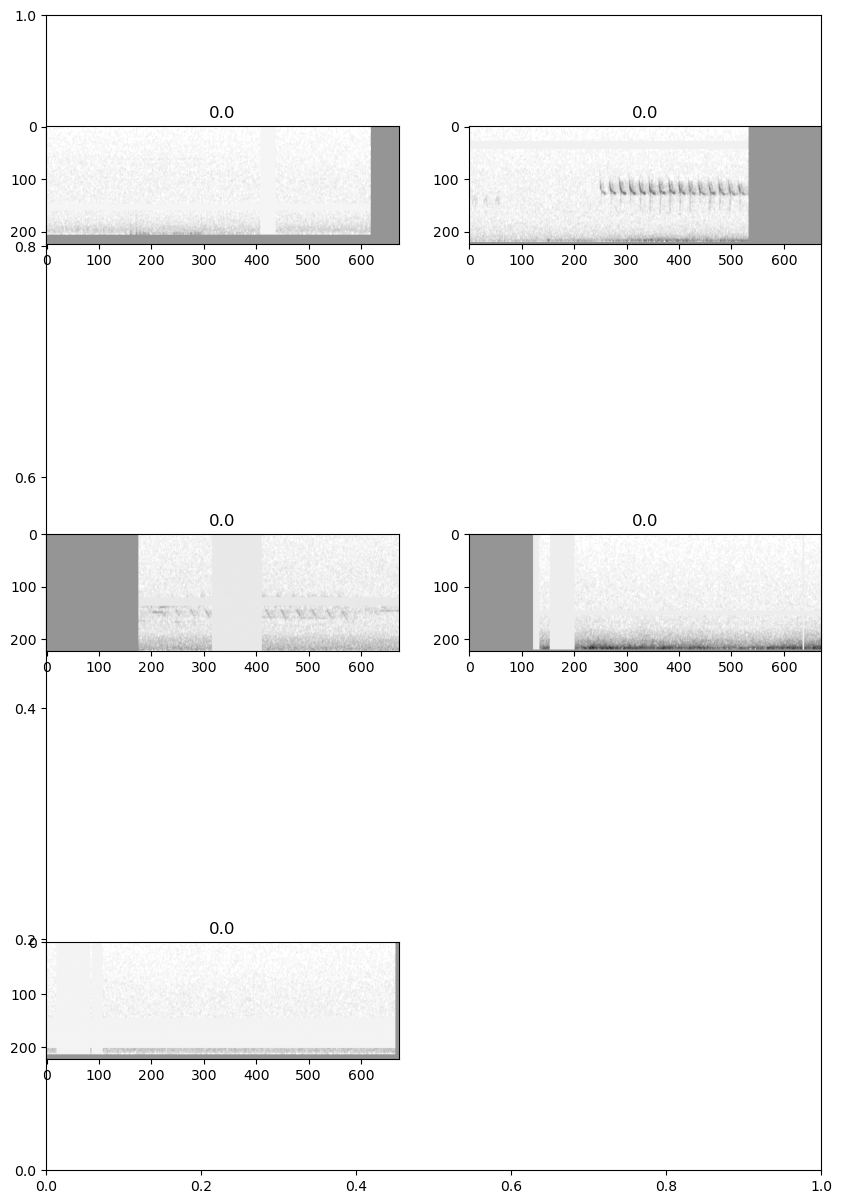

In [76]:
train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train, target_species = "OSFL", download_n=0)

In [77]:
train_df = train_dataset.label_df
valid_df = valid_dataset.label_df

In [78]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    42604
 1.0     4030
 Name: count, dtype: int64,
 target_presence
 0.0    12424
 1.0     1224
 Name: count, dtype: int64)

In [80]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that all classes have 800 samples
balanced_train_df = resample(train_df,n_samples_per_class=800,random_state=0)

In [81]:
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    800
 1.0    800
 Name: count, dtype: int64,
 1600)

In [238]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
model.single_target = True


In [239]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

In [240]:
class_list

['target_absence', 'target_presence']

In [241]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


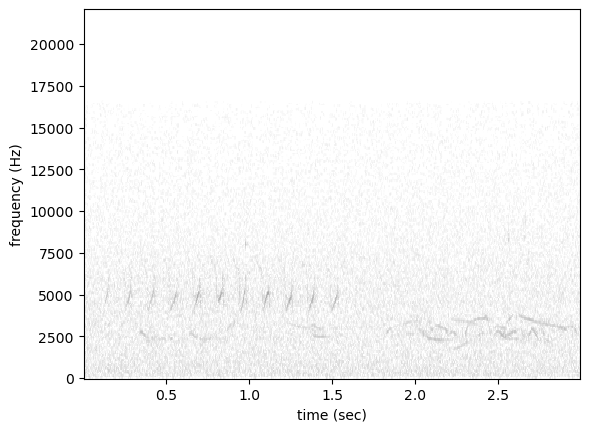

In [242]:
show_sample(present=True)

In [243]:
print(f'model.device is: {model.device}')

model.device is: mps


In [244]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    config={
    "epochs":6,
    "log_histograms":False,
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▂▃▄▅▆▇█
loss,█▇▅▃▂▂▁▁
epoch,7
loss,0.36229


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [245]:
balanced_train_df

,,,target_absence,target_presence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-100133.flac,111.0,114.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-4837.mp3,33.0,36.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-417005.flac,106.5,109.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-552869.flac,138.0,141.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-398418.flac,25.5,28.5,1.0,0.0
...,...,...,...,...
../../data/raw/recordings/OSFL/recording-218582.mp3,39.0,42.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-553394.flac,0.0,3.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-555982.flac,7.5,10.5,0.0,1.0


In [246]:
model.train(
    balanced_train_df,
    valid_df,
    epochs = 8,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 [batch 0/25, 0.00%] 
	DistLoss: 0.713
Metrics:
Epoch: 0 [batch 10/25, 40.00%] 
	DistLoss: 0.708
Metrics:
Epoch: 0 [batch 20/25, 80.00%] 
	DistLoss: 0.699
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 [batch 0/25, 0.00%] 
	DistLoss: 0.642
Metrics:
Epoch: 1 [batch 10/25, 40.00%] 
	DistLoss: 0.650
Metrics:
Epoch: 1 [batch 20/25, 80.00%] 
	DistLoss: 0.621
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 2


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2 [batch 0/25, 0.00%] 
	DistLoss: 0.639
Metrics:
Epoch: 2 [batch 10/25, 40.00%] 
	DistLoss: 0.516
Metrics:
Epoch: 2 [batch 20/25, 80.00%] 
	DistLoss: 0.520
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 3


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3 [batch 0/25, 0.00%] 
	DistLoss: 0.409
Metrics:
Epoch: 3 [batch 10/25, 40.00%] 
	DistLoss: 0.501
Metrics:
Epoch: 3 [batch 20/25, 80.00%] 
	DistLoss: 0.484
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 4


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4 [batch 0/25, 0.00%] 
	DistLoss: 0.427
Metrics:
Epoch: 4 [batch 10/25, 40.00%] 
	DistLoss: 0.444
Metrics:
Epoch: 4 [batch 20/25, 80.00%] 
	DistLoss: 0.426
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 5


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5 [batch 0/25, 0.00%] 
	DistLoss: 0.424
Metrics:
Epoch: 5 [batch 10/25, 40.00%] 
	DistLoss: 0.386
Metrics:
Epoch: 5 [batch 20/25, 80.00%] 
	DistLoss: 0.397
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 6


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6 [batch 0/25, 0.00%] 
	DistLoss: 0.372
Metrics:
Epoch: 6 [batch 10/25, 40.00%] 
	DistLoss: 0.388
Metrics:
Epoch: 6 [batch 20/25, 80.00%] 
	DistLoss: 0.404
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 7


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7 [batch 0/25, 0.00%] 
	DistLoss: 0.304
Metrics:
Epoch: 7 [batch 10/25, 40.00%] 
	DistLoss: 0.360
Metrics:
Epoch: 7 [batch 20/25, 80.00%] 
	DistLoss: 0.360
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Best Model Appears at Epoch 3 with Validation score 0.639.


In [247]:
model.valid_metrics

{0: {'confusion_matrix': array([[ 1450, 10974],
         [   60,  1164]]),
  'precision': 0.09589718240237272,
  'recall': 0.9509803921568627,
  'f1': 0.1742254153569825,
  'jaccard': 0.10578707494239946,
  'hamming_loss': 0.8084701055099648},
 1: {'confusion_matrix': array([[ 2382, 10042],
         [   19,  1205]]),
  'precision': 0.10713968169289588,
  'recall': 0.9844771241830066,
  'f1': 0.19324833613984446,
  'jaccard': 0.1491959629180856,
  'hamming_loss': 0.7371776084407972},
 2: {'confusion_matrix': array([[8027, 4397],
         [  94, 1130]]),
  'precision': 0.20445087751040347,
  'recall': 0.923202614379085,
  'f1': 0.33476521996741226,
  'jaccard': 0.4211342320678575,
  'hamming_loss': 0.32905920281359907},
 3: {'confusion_matrix': array([[11811,   613],
         [  362,   862]]),
  'precision': 0.584406779661017,
  'recall': 0.704248366013072,
  'f1': 0.6387550944794369,
  'jaccard': 0.6964940261535715,
  'hamming_loss': 0.0714390386869871},
 4: {'confusion_matrix': array([

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [249]:
# save the splits
pd.to_pickle(valid_df, data_path / "interim" / "valid_set" / "valid_df_swap.pkl")
pd.to_pickle(train_df, data_path / "interim" / "train_set" / "train_df_swap.pkl")



In [250]:
# save the model too
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / "osfl_model_28022024_swap")

In [251]:
best_model.valid_metrics

{0: {'confusion_matrix': array([[ 1450, 10974],
         [   60,  1164]]),
  'precision': 0.09589718240237272,
  'recall': 0.9509803921568627,
  'f1': 0.1742254153569825,
  'jaccard': 0.10578707494239946,
  'hamming_loss': 0.8084701055099648},
 1: {'confusion_matrix': array([[ 2382, 10042],
         [   19,  1205]]),
  'precision': 0.10713968169289588,
  'recall': 0.9844771241830066,
  'f1': 0.19324833613984446,
  'jaccard': 0.1491959629180856,
  'hamming_loss': 0.7371776084407972},
 2: {'confusion_matrix': array([[8027, 4397],
         [  94, 1130]]),
  'precision': 0.20445087751040347,
  'recall': 0.923202614379085,
  'f1': 0.33476521996741226,
  'jaccard': 0.4211342320678575,
  'hamming_loss': 0.32905920281359907},
 3: {'confusion_matrix': array([[11811,   613],
         [  362,   862]]),
  'precision': 0.584406779661017,
  'recall': 0.704248366013072,
  'f1': 0.6387550944794369,
  'jaccard': 0.6964940261535715,
  'hamming_loss': 0.0714390386869871}}

In [252]:

model.train(
    balanced_train_df,
    valid_df,
    epochs = 6,
    batch_size = 64,
    log_interval = 100, #log progress every 100 batches
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    save_interval = 10, #save checkpoint every 10 epochs
)


Training Epoch 8


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8 [batch 0/25, 0.00%] 
	DistLoss: 0.309
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 9


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9 [batch 0/25, 0.00%] 
	DistLoss: 0.233
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 10


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 [batch 0/25, 0.00%] 
	DistLoss: 0.345
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 11


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11 [batch 0/25, 0.00%] 
	DistLoss: 0.175
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 12


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 [batch 0/25, 0.00%] 
	DistLoss: 0.345
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 13


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13 [batch 0/25, 0.00%] 
	DistLoss: 0.394
Metrics:
Metrics:

Validation.


  0%|          | 0/214 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Best Model Appears at Epoch 8 with Validation score 0.658.


The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence, and the ordering of the labels in the source dataframe was making large differences to the reported metrics. If the absent label is at the 0th index and the present label is at index 1, the metrics look great, but swapping the order of the columns affects the scores. 

Intuitively this shouldn't matter - the classes are still being matched up to the same labels. 
I think there are two things happening here:
1. When the metrics are calculated, opso or sklearn expects that the positive class will be at the 1st index and the negative class will be at the 0th index. This makes sense - since that would make the result of argmax equal to 1 for the present class and 0 for the absent class. 

This still leaves the question of why the metrics would look better when considering the absent class as the positive class rather than the other way around. There are a few things going on here:
- In the training set, there are the same number of present clips as absent clips but in the validation set there are far more absent clips than present clips. 
- When we considered the absent class to be the target class, the scores were higher. This might suggest that the model is better at predicting absent than it is at predicting presence. I could test this theory by measuring the metrics only on the absent class, then only on the present class.

Why could this be?
- It might be that there are more incorrectly labelled present clips than there are absent clips.  If noisy present labels are the issue, then that's a relatively quick fix. 

I can now check the effect of cleaning the dataset. 

In [40]:
model.loss_hist

{0: 0.7151592,
 1: 0.70560485,
 2: 0.7087473,
 3: 0.71182,
 4: 0.74260056,
 5: 0.6989925,
 6: 0.71470064,
 7: 0.7171962}

In [49]:
model.valid_metrics

{0: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.9027106949236077,
  'recall': 1.0,
  'f1': 0.9488680515981972,
  'jaccard': 0.45135534746180384,
  'hamming_loss': 0.09728930507639232},
 1: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.9027106949236077,
  'recall': 1.0,
  'f1': 0.9488680515981972,
  'jaccard': 0.45135534746180384,
  'hamming_loss': 0.09728930507639232},
 2: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.9027106949236077,
  'recall': 1.0,
  'f1': 0.9488680515981972,
  'jaccard': 0.45135534746180384,
  'hamming_loss': 0.09728930507639232},
 3: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.9027106949236077,
  'recall': 1.0,
  'f1': 0.9488680515981972,
  'jaccard': 0.45135534746180384,
  'hamming_loss': 0.09728930507639232},
 4: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.902710694923

In [37]:
train_dataset.class_counts()
valid_dataset.class_counts()

(Index(['target_presence', 'target_absence'], dtype='object'),
 array([ 987., 9158.]))

In [38]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

# Make predictions on the validation set
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

In [68]:
from opensoundscape.ml.cnn import load_model
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [69]:


#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [70]:
torch.hub.list('kitzeslab/bioacoustics-model-zoo')

Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


['BirdNET', 'Perch', 'SeparationModel', 'YAMNet', 'rana_sierrae_cnn']

In [75]:
valid_dataset.label_df

target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4454.mp3  1.5        4.5                   1.0   
                                                   3.0        6.0                   1.0   
                                                   60.0       63.0                  1.0   
                                                   93.0       96.0                  1.0   
                                                   118.5      121.5                 1.0   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-826104... 6.0        9.0                   0.0   
                                                   7.5        10.5                  0.0   
                                                   9.0        12.0                  0.0   
                                                   10.5       13.5                  0.0   
                                                   13.5       16.5                  1.0   

                                                                        target_absence  
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-4454.mp3  1.5        4.5                  0.0  
                                                   3.0        6.0                  0.0  
                                                   60.0       63.0                 0.0  
                                                   93.0       96.0                 0.0  
                                                   118.5      121.5                0.0  
...                                                                                ...  
../../data/raw/recordings/OSFL/recording-826104... 6.0        9.0                  1.0  
                                                   7.5        10.5                 1.0  
                                                   9.0        12.0                 1.0  
                                                   10.5       13.5                 1.0  
                                                   13.5       16.5                 0.0  

[10145 rows x 2 columns]

In [76]:
model.predict(valid_dataset.label_df)

  0%|          | 0/10145 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4454.mp3  1.5        4.5              0.356499   
                                                   3.0        6.0              0.356499   
                                                   60.0       63.0             0.356499   
                                                   93.0       96.0             0.356499   
                                                   118.5      121.5            0.356499   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-826104... 6.0        9.0              0.356499   
                                                   7.5        10.5             0.356499   
                                                   9.0        12.0             0.356499   
                                                   10.5       13.5             0.356499   
                                                   13.5       16.5             0.356499   

                                                                        target_absence  
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-4454.mp3  1.5        4.5            -0.464677  
                                                   3.0        6.0            -0.464677  
                                                   60.0       63.0           -0.464677  
                                                   93.0       96.0           -0.464677  
                                                   118.5      121.5          -0.464677  
...                                                                                ...  
../../data/raw/recordings/OSFL/recording-826104... 6.0        9.0            -0.464677  
                                                   7.5        10.5           -0.464677  
                                                   9.0        12.0           -0.464677  
                                                   10.5       13.5           -0.464677  
                                                   13.5       16.5           -0.464677  

[10145 rows x 2 columns]

In [111]:
sample = valid_dataset.label_df.sample(10)
sample

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-555686.flac,24.0,27.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-553501.flac,177.0,180.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-487923.flac,1.5,4.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-555612.flac,33.0,36.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-552598.flac,112.5,115.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-555688.flac,13.5,16.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-248719.mp3,22.5,25.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-622364.flac,30.0,33.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-553723.flac,145.5,148.5,0.0,1.0


In [113]:
model.predict(sample)

  0%|          | 0/10 [00:00<?, ?it/s]

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-555686.flac,24.0,27.0,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-553501.flac,177.0,180.0,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-487923.flac,1.5,4.5,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-555612.flac,33.0,36.0,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-552598.flac,112.5,115.5,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-555688.flac,13.5,16.5,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-248719.mp3,22.5,25.5,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-622364.flac,30.0,33.0,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-553723.flac,145.5,148.5,0.356499,-0.464677


The model isn't changing its prdictions at all with different inputs. 

In [114]:
model.preprocessor()

Preprocessor with pipeline:
load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Augmentation Action calling <function trim_aud...
trim_audio           Action calling <function trim_audio at 0x17cda...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_tensor                                                       Action
time_mask            Augmentation Action calling <function time_mas...
frequency_mask       Augmentation Action calling <function frequenc...
add_noise            Augmentation Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x17c...
random_affine        Augmentation Action calling <function torch_ra...
dtype: object

model.predict() is returning the same value for all inputs.

In [115]:
model.generate_samples(sample)

[AudioSample(source=../../data/raw/recordings/OSFL/recording-555686.flac, start_time=24.0,end_time=27.0, labels=target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-555686.flac, 24.0, 27.0), dtype: float64),
 AudioSample(source=../../data/raw/recordings/OSFL/recording-553501.flac, start_time=177.0,end_time=180.0, labels=target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-553501.flac, 177.0, 180.0), dtype: float64),
 AudioSample(source=../../data/raw/recordings/OSFL/recording-487923.flac, start_time=1.5,end_time=4.5, labels=target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-487923.flac, 1.5, 4.5), dtype: float64),
 AudioSample(source=../../data/raw/recordings/OSFL/recording-555612.flac, start_time=33.0,end_time=36.0, labels=target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-555612.flac, 33.0, 36.0), dtype: float6